In [1]:
import obspy
from s3fs import S3FileSystem
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seisbench.models as sbm
import seisbench.util as sbu
import pyocto
import cartopy.crs as ccrs
import datetime

In [2]:
fs = S3FileSystem(anon=True)

In [3]:
fs.ls("ncedc-pds/FDSNstationXML/")

['ncedc-pds/FDSNstationXML/',
 'ncedc-pds/FDSNstationXML/BK',
 'ncedc-pds/FDSNstationXML/BP',
 'ncedc-pds/FDSNstationXML/NC',
 'ncedc-pds/FDSNstationXML/NP']

In [4]:
stations = fs.ls("ncedc-pds/FDSNstationXML/BK")[1:]

## Load inventories

In [5]:
inv = obspy.Inventory()
for station in tqdm(stations):
    with fs.open(station) as f:
        inv += obspy.read_inventory(f)

  0%|          | 0/185 [00:00<?, ?it/s]

In [6]:
inv.select(channel="HH?")

Inventory created at 2024-01-27T20:21:57.205413Z
	Created by: ObsPy 1.4.0
		    https://www.obspy.org
	Sending institution: NCEDC,ObsPy 1.4.0 (NCEDC)
	Contains:
		Networks (159):
			BK (159x)
		Stations (300):
			BK.AASB (Rancho Murieta, CA)
			BK.ADAM (Adams Ridge, Knoxville, Napa County)
			BK.ALVW (Alview elementary school)
			BK.AONC (Abbey of New Clairvaux, Vina, CA)
			BK.ARC (Humboldt State University, Arcata, CA, USA)
			BK.ATP (Archer Taylor Preserve)
			BK.BABI (Babies Gulch, Panoche, CA)
			BK.BAKR (Baker Fire Station, Cottonwood, CA)
			BK.BARR (Barra Winery, Redwood Valley, CA)
			BK.BAYL (Bayliss; Glenn County)
			BK.BCCR (Big Chico Creek, Paradise, CA USA)
			BK.BDM (Black Diamond Mines Park, Antioch, CA, USA)
			BK.BIGV (Big Valley, Lassen County)
			BK.BJES (Bald Jesse, Humboldt County, CA)
			BK.BKS (Byerly Seismographic Vault, Berkeley, CA, USA) (2x)
			BK.BL67 (LBL Building 67, Berkeley, CA, USA)
			BK.BLAS (Black Lassic)
			BK.BLUE (Blue Mountain)
			BK.BONV (Bradf

## Select stations

In [7]:
cand = []
minlon = -125
maxlon = -123
minlat = 39.5
maxlat = 41

for net in inv.select(channel="HH?"):
    for sta in net:
        if minlon < sta.longitude < maxlon and minlat < sta.latitude < maxlat:
            cand.append(sta)

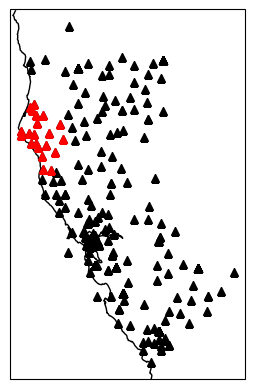

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.coastlines("10m")

for net in inv:
    for sta in net:
        ax.plot(sta.longitude, sta.latitude, "k^", transform=ccrs.PlateCarree())

for sta in cand:
    ax.plot(sta.longitude, sta.latitude, "r^", transform=ccrs.PlateCarree())

In [9]:
sorted([sta.code for sta in cand])

['ARC',
 'BJES',
 'BLAS',
 'BRIC',
 'DMOR',
 'GHOP',
 'HALS',
 'HAYF',
 'HUNT',
 'INGL',
 'JCC',
 'JEWT',
 'KNEE',
 'KRUG',
 'PETL',
 'PRDS',
 'RBOW',
 'RVIT',
 'SHWD',
 'SPRL',
 'WLKR']

## Download and pick data

In [10]:
year = 2022
day = 354

model = sbm.PhaseNet.from_pretrained("instance")

picks = sbu.PickList()
for station in tqdm([sta.code for sta in cand]):
    stream = obspy.Stream()
    for c in "ZNE":
        url = f"ncedc-pds/continuous_waveforms/BK/{year}/{year}.{day:03d}/{station}.BK.HH{c}.00.D.{year}.{day:03d}"
        try:
            with fs.open(url) as f:
                trace = obspy.read(f)
                t0 = min(t.stats.starttime for t in trace)
                trace.trim(endtime=t0 + 24 * 60 * 60)
                stream += trace
        except FileNotFoundError:
            print(f"No data for station {station}")
            break
    if len(stream) > 0:
        picks += model.classify(stream, P_threshold=0.2, S_threshold=0.2).picks

  0%|          | 0/21 [00:00<?, ?it/s]

No data for station ARC


2024-01-27 20:22:03,348 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
2024-01-27 20:22:05,887 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.


No data for station BLAS
No data for station GHOP
No data for station HALS
No data for station HUNT
No data for station INGL
No data for station JCC
No data for station JEWT
No data for station KRUG


2024-01-27 20:23:16,781 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
2024-01-27 20:23:17,178 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2024-01-27 20:23:17,179 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2024-01-27 20:23:18,557 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.


No data for station SHWD
No data for station SPRL
No data for station WLKR


In [11]:
picks

PickList with 7765 entries:

BK.BJES.00	2022-12-20T10:34:34.760000Z	P
BK.BJES.00	2022-12-20T10:38:08.000000Z	P
BK.BJES.00	2022-12-20T10:38:11.490000Z	S
...
BK.RVIT.00	2022-12-20T14:57:28.320000Z	P
BK.RVIT.00	2022-12-20T17:34:08.300000Z	P
BK.RVIT.00	2022-12-20T21:14:53.530000Z	P

## Associate

In [12]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=6.0,
    s_velocity=3.4,
    tolerance=1.5
)

associator = pyocto.OctoAssociator.from_area(
    lat=(minlat - 0.4, maxlat + 0.4),
    lon=(minlon - 0.4, maxlon + 0.4),
    zlim=(0, 50),
    time_before=100,
    velocity_model=velocity_model,
    n_picks=8,
    n_p_picks=3,
    n_s_picks=3,
    n_p_and_s_picks=3,
)

stations_pyocto = associator.inventory_to_df(inv)

In [13]:
events, assignments = associator.associate_seisbench(picks, stations_pyocto)

In [14]:
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2022-12-20 03:06:59.837898+00:00,-35.481024,6.994281,20.703125,8,40.312236,-124.417405,20.703125
1,1,2022-12-20 10:29:22.540804+00:00,-30.750221,17.007437,19.921875,8,40.402596,-124.362235,19.921875
2,2,2022-12-20 10:34:24.441170+00:00,-34.534864,40.037694,12.890625,11,40.609840,-124.408071,12.890625
3,3,2022-12-20 10:38:02.674132+00:00,-0.473080,46.045588,24.609375,15,40.664663,-124.005595,24.609375
4,4,2022-12-20 10:39:01.841587+00:00,-11.827008,31.025854,30.859375,15,40.529322,-124.139583,30.859375
...,...,...,...,...,...,...,...,...,...
384,384,2022-12-20 23:43:10.521341+00:00,-37.373345,35.031116,23.046875,12,40.564632,-124.441314,23.046875
385,385,2022-12-20 23:44:41.209464+00:00,5.203884,49.049534,30.078125,9,40.691697,-123.938435,30.078125
386,386,2022-12-20 23:49:22.043713+00:00,-11.827008,48.048219,28.515625,9,40.682612,-124.139903,28.515625
387,387,2022-12-20 23:52:09.677286+00:00,-26.965578,30.024539,32.421875,8,40.519951,-124.318205,32.421875


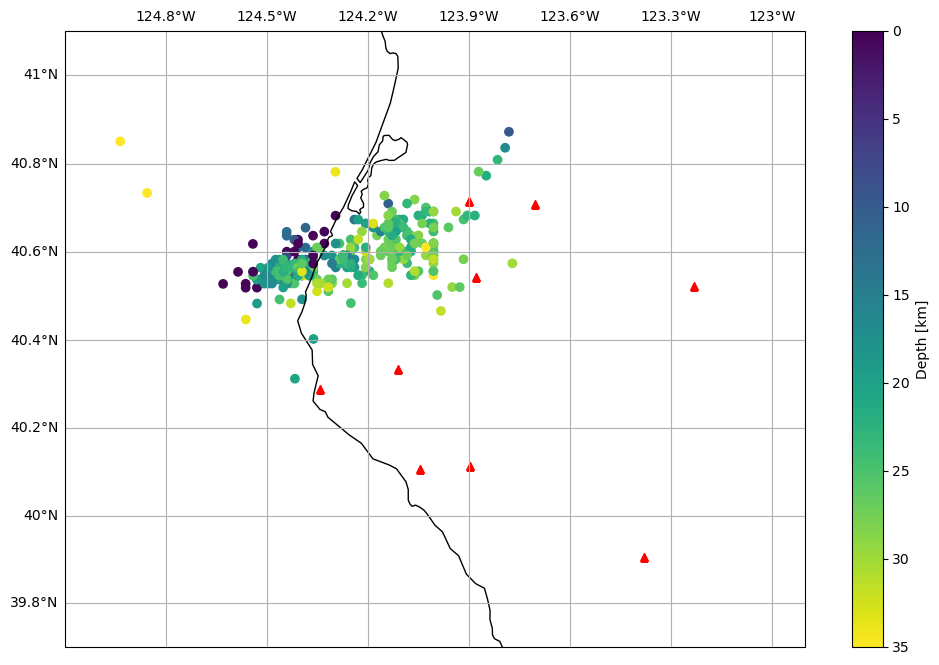

In [15]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.bottom_labels = False
gl.right_labels = False

active_stations = set([x.trace_id.split(".")[1] for x in picks])

cb = ax.scatter(events["longitude"], events["latitude"], c=events["depth"], transform=ccrs.PlateCarree(), vmin=0, vmax=35)
for sta in cand:
    if sta.code in active_stations:
        ax.plot(sta.longitude, sta.latitude, "r^", transform=ccrs.PlateCarree())
ax.set_extent([minlon - 0.1, maxlon + 0.1, minlat + 0.2, maxlat + 0.1], crs=ccrs.PlateCarree())
cax = fig.colorbar(cb, label="Depth [km]")
cax.ax.invert_yaxis()